## EEE485 - Project Final

### Imports

In [2]:
import csv
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import numpy.linalg as LA
import smote
import random
import kNN
import fcn
import PCA
from numba import njit, jit
import scipy

### Load Data

In [3]:
raw_data = pd.read_csv("data.csv")
bankrupt_pd = raw_data["Bankrupt?"]
features_pd = raw_data.drop(["Bankrupt?"], axis=1)
raw_data

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6814,0,0.493687,0.539468,0.543230,0.604455,0.604462,0.998992,0.797409,0.809331,0.303510,...,0.799927,0.000466,0.623620,0.604455,0.840359,0.279606,0.027064,0.566193,1,0.029890
6815,0,0.475162,0.538269,0.524172,0.598308,0.598308,0.998992,0.797414,0.809327,0.303520,...,0.799748,0.001959,0.623931,0.598306,0.840306,0.278132,0.027009,0.566018,1,0.038284
6816,0,0.472725,0.533744,0.520638,0.610444,0.610213,0.998984,0.797401,0.809317,0.303512,...,0.797778,0.002840,0.624156,0.610441,0.840138,0.275789,0.026791,0.565158,1,0.097649
6817,0,0.506264,0.559911,0.554045,0.607850,0.607850,0.999074,0.797500,0.809399,0.303498,...,0.811808,0.002837,0.623957,0.607846,0.841084,0.277547,0.026822,0.565302,1,0.044009


### Check for NAN and Duplicate Values


In [4]:
print("NAN values:", [col for col in features_pd if features_pd[col].isna().sum() > 0])
print("Duplicates:", features_pd.duplicated().sum())

NAN values: []
Duplicates: 0


We now know that we do not have any missing or duplicate data

### Evaluate Data Imbalance

In [5]:
unstable_initial = (raw_data["Bankrupt?"] == 1).sum()
stable_initial = (raw_data["Bankrupt?"] == 0).sum()
print("Data Size:", raw_data.shape[0])
print("# of stable companies:", stable_initial )
print("# of unstable companies:", unstable_initial )
print("Unstable to Stable Ratio: ", unstable_initial/stable_initial)

Data Size: 6819
# of stable companies: 6599
# of unstable companies: 220
Unstable to Stable Ratio:  0.03333838460372784


### PLOTS

In [ ]:
raw_data.hist(figsize = (50,40), bins = 50)
plt.show()

In [ ]:
f, axes = plt.subplots(ncols=4, figsize = (24,6) )

sns.boxplot(x="Bankrupt?", y=" Cash/Total Assets", data=raw_data, ax = axes[0] )
axes[0].set_title("Bankrupt vs Cash/Total Assets")

sns.boxplot(x="Bankrupt?", y=" Current Assets/Total Assets", data=raw_data, ax = axes[1] )
axes[1].set_title("Bankrupt vs Current Assets/Total Assets")

sns.boxplot(x="Bankrupt?", y=" Net worth/Assets", data=raw_data, ax = axes[2] )
axes[2].set_title("Bankrupt vs Net worth/Assets")

sns.boxplot(x="Bankrupt?", y=" Cash/Current Liability", data=raw_data, ax = axes[3] )
axes[3].set_title("Bankrupt vs Cash/Current Liability")

plt.show()

### Outlier Removal Using IQR

In [6]:
clean_data = raw_data.copy(deep=True)
for col in features_pd:
    clean_data = fcn.remove_outlier(raw_data[col], str(col), raw_data)
clean_data = clean_data.reset_index(drop=True)
clean_data

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,0,0.491639,0.549498,0.537877,0.613219,0.613168,0.998999,0.797436,0.809344,0.303543,...,0.806743,0.000548,0.623743,0.613219,0.840676,0.276560,0.026811,0.565253,1,0.061753
6266,0,0.477600,0.531127,0.526099,0.595829,0.595858,0.998905,0.797375,0.809294,0.303634,...,0.794028,0.003475,0.623398,0.595827,0.839864,0.281325,0.022309,0.571752,1,0.024803
6267,0,0.493687,0.539468,0.543230,0.604455,0.604462,0.998992,0.797409,0.809331,0.303510,...,0.799927,0.000466,0.623620,0.604455,0.840359,0.279606,0.027064,0.566193,1,0.029890
6268,0,0.475162,0.538269,0.524172,0.598308,0.598308,0.998992,0.797414,0.809327,0.303520,...,0.799748,0.001959,0.623931,0.598306,0.840306,0.278132,0.027009,0.566018,1,0.038284


### Plots with Outliers Removed

In [ ]:
clean_data.hist(figsize = (50,40), bins = 50)
plt.show()

In [ ]:
f, axes = plt.subplots(ncols=4, figsize = (24,6) )

sns.boxplot(x="Bankrupt?", y=" Cash/Total Assets", data=clean_data, ax = axes[0] )
axes[0].set_title("Bankrupt vs Cash/Total Assets")

sns.boxplot(x="Bankrupt?", y=" Current Assets/Total Assets", data=clean_data, ax = axes[1] )
axes[1].set_title("Bankrupt vs Current Assets/Total Assets")

sns.boxplot(x="Bankrupt?", y=" Net worth/Assets", data=clean_data, ax = axes[2] )
axes[2].set_title("Bankrupt vs Net worth/Assets")

sns.boxplot(x="Bankrupt?", y=" Cash/Current Liability", data=clean_data, ax = axes[3] )
axes[3].set_title("Bankrupt vs Cash/Current Liability")

plt.show()

### PCA

In [7]:
import numpy as np
import numpy.linalg as LA

class PCAnalyser():

    def __init__(self, X: np.ndarray, data_centered=False) -> None:
        if data_centered:
            self.X = X
        else:
            self.X = X - np.mean(X, axis=0)
        self.Sigma = self.X.T @ self.X
        self.eigs = np.array([])
        return

    def analyse(self, k = 10):
        if k > self.Sigma.shape[0]: return

        eig_vals, eig_vecs = LA.eigh(self.Sigma)
        idx = np.argsort(eig_vals)[::-1]
        self.eigs = eig_vals[idx]
        eig_vecs = eig_vecs[:,idx]
        PCs = eig_vecs[:,0:k]

        return self.eigs, PCs

    def calc_PVE(self, m=10, individual=False):
        m = np.clip(m, 0, len(self.eigs))
        if individual:
            return self.eigs[m] / sum(self.eigs) # PVE(m)
        return sum(self.eigs[:m+1]) / sum(self.eigs) # PVE(first m)

In [8]:
clean_X = clean_data.drop(["Bankrupt?"], axis=1)
clean_Y = clean_data["Bankrupt?"]
centered_data = clean_X - np.mean(clean_X, axis=0)
pc_analyser = PCAnalyser(centered_data, data_centered=True)
eigen_vals, PCs = pc_analyser.analyse(k=7)

(0.0, 30.0)

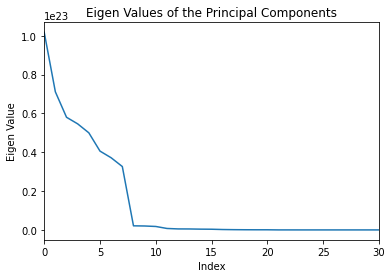

In [9]:
plt.figure(figsize=(6,4))
plt.plot(eigen_vals)
plt.xlabel("Index")
plt.ylabel("Eigen Value")
plt.title("Eigen Values of the Principal Components")
plt.xlim( (0, 30) )

In [10]:
PCA_data = centered_data @ PCs

In [11]:
PCA_data.columns = ("PC"+str(i) for i in range(1,8))
print("Shape of the Feature Matrix after PCA is:", PCA_data.shape)
PCA_data = pd.concat([clean_Y, PCA_data], axis=1)

Shape of the Feature Matrix after PCA is: (6270, 7)


### SMOTE

In [14]:
minority = PCA_data[PCA_data["Bankrupt?"] == 1] # Extract minority samples from data
smt = smote.Smote( minority.to_numpy() ) # Initialize the SMOTE class
oversamples = smt.oversample(N=2600) # Employ SMOTE oversampling


In [15]:
smote_data = PCA_data.copy(deep=True) # Cleared from outliers and dim reduced by PCA. Now oversample
oversamples_pd = pd.DataFrame(oversamples, columns = PCA_data.columns)
smote_data = smote_data.append(oversamples_pd)
smote_data = smote_data.reset_index(drop=True)

In [16]:
unstable_smote = (smote_data["Bankrupt?"] == 1).sum()
stable_smote = (smote_data["Bankrupt?"] == 0).sum()
print("Oversampled Data Size:", smote_data.shape[0])
print("Number of Stable Companies:", stable_smote)
print("Number of Unstable Companies (with SMOTE):", unstable_smote)
print("unstable to Stable Ratio: ", unstable_smote/stable_smote, sep="")

Oversampled Data Size: 11938
Number of Stable Companies: 6052
Number of Unstable Companies (with SMOTE): 5886
unstable to Stable Ratio: 0.972571050892267


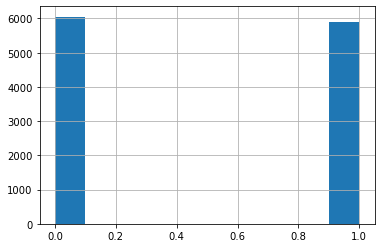

In [12]:
smote_data["Bankrupt?"].hist()
plt.show()

### Test Train Split

In [30]:
test_ratio = 0.1
#Smote
smote_data = smote_data.sample(frac=1).reset_index(drop=True)
train_sm, test_sm = fcn.test_train_split(smote_data, test_ratio )
X_train_sm = train_sm.drop(["Bankrupt?"], axis=1)
Y_train_sm = train_sm["Bankrupt?"]
X_test_sm = test_sm.drop(["Bankrupt?"], axis=1)
Y_test_sm = test_sm["Bankrupt?"]
#No Smote
train, test = fcn.test_train_split(PCA_data, test_ratio )
X_train = train.drop(["Bankrupt?"], axis=1)
Y_train = train["Bankrupt?"]
X_test = test.drop(["Bankrupt?"], axis=1)
Y_test = test["Bankrupt?"]

X_train_np = X_train.to_numpy()
Y_train_np = Y_train.to_numpy()
X_test_np = X_test.to_numpy()
Y_test_np = Y_test.to_numpy()
X_train_sm_np = X_train_sm.to_numpy()
Y_train_sm_np = Y_train_sm.to_numpy()
X_test_sm_np = X_test_sm.to_numpy()
Y_test_sm_np = Y_test_sm.to_numpy()


### k-Nearest Neighbors Classifier (with and without SMOTE)

In [31]:
knn_classifier = kNN.k_NN_classifier(X_train_np, Y_train_np )
knn_preds = np.zeros_like(Y_test_np)
for idx, test in enumerate(X_test_np):
    knn_preds[idx] = knn_classifier.classify(test)

knn_classifier_sm = kNN.k_NN_classifier(X_train_sm_np, Y_train_sm_np )
knn_sm_preds = np.zeros_like(Y_test_sm_np)
for idx, test in enumerate(X_test_sm_np):
    knn_sm_preds[idx] = knn_classifier_sm.classify(test)


In [32]:
print("Confusion Matrix Without SMOTE")
conf_matrix = fcn.confusion_matrix(Y_test_np, knn_preds, ret = True)

print("Recall:", conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[1,0]) * 100 )
print("Precision:", conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[0,1]) * 100 )
print()
print("Confusion Matrix With SMOTE")
conf_matrix_sm = fcn.confusion_matrix(Y_test_sm_np, knn_sm_preds, ret = True)
print("Recall:", conf_matrix_sm[0,0]/(conf_matrix_sm[0,0]+conf_matrix_sm[1,0]) * 100 )
print("Precision:", conf_matrix_sm[0,0]/(conf_matrix_sm[0,0]+conf_matrix_sm[0,1]) *100 )

Confusion Matrix Without SMOTE
 	1	0 (prediction)
1	0	21
0	0	606
Recall: nan
Precision: 0.0

Confusion Matrix With SMOTE
 	1	0 (prediction)
1	537	32
0	101	523
Recall: 84.1692789968652
Precision: 94.37609841827768
<ipython-input-32-5c16df14f5d7>:4: RuntimeWarning: invalid value encountered in long_scalars
  print("Recall:", conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[1,0]) * 100 )


### Logistic Regression

In [ ]:
class Logistic_regression(object):

    def __init__(self, size) -> None:
        selfb = np.random.rand(size,1)
        pass
    
    
    def sigmoid(z):
        sig = 1.0 / (1 + np.exp(-z))
        return sig

    def pred(features, weight):
        y = features@weight
        return Logistic_regression.sigmoid(y)


    def classify(prediction, boundary=0.50):
        return prediction > boundary


    def cost_func(self, features:np.ndarray, labels):
        prediction = Logistic_regression.pred(features,self.b)
        cost = (-labels*np.log(prediction)-(1-labels)*np.log(1-prediction))
        average = cost.sum() / len(features)
        return average

    def gradient_descent( features:np.ndarray, labels, weight, learning_rate = 0.03):
        prediction = Logistic_regression.pred(features, weight)
        mid = prediction - labels
        gradient = features.T@ mid
        gradient = gradient / len(features)
        gradient = gradient * learning_rate
        weight = weight - gradient
        return weight

In [ ]:
log_reg = Logistic_regression(7)
initial_weights = np.random.rand(7,1)
X_train_sm_np = X_train_sm.to_numpy()
Y_train_sm_np = Y_train_sm.to_numpy()
weights = Logistic_regression.gradient_descent(X_train_sm_np, Y_train_sm_np.reshape(len(Y_train_sm_np),1), initial_weights)
for idx in range(10000):
    weights = Logistic_regression.gradient_descent(X_train_sm_np, Y_train_sm_np.reshape(len(Y_train_sm_np),1), weights)
final_pred =Logistic_regression.pred(X_test_sm_np, weights)
result = Logistic_regression.classify(final_pred)

In [ ]:
conf_matrix_sm_lr = fcn.confusion_matrix(Y_test_sm_np.T, result.T*1, ret = True)
print("Recall:", conf_matrix_sm_lr[0,0]/(conf_matrix_sm_lr[0,0]+conf_matrix_sm_lr[1,0]) * 100 )
print("Precision:", conf_matrix_sm_lr[0,0]/(conf_matrix_sm_lr[0,0]+conf_matrix_sm_lr[0,1]) *100 )

### Gradient Boosting Classifier

In [18]:
@njit(fastmath=True)
def divide_on_feature(X, col_idx, th):
    mask = X[:,col_idx] >= th
    X1 = X[mask]
    X2 = X[~mask]
    valid = X1.size != 0 and X2.size != 0
    return X1, X2, valid


class DecisionNode():
    "Node Struct"
    def __init__(self, col_idx=None, th=None,
                 value=None, true_branch=None, false_branch=None):
        self.col_idx = col_idx          
        self.th = th      
        self.value = value              
        self.true_branch = true_branch  
        self.false_branch = false_branch

class DecisionTree(object):
    def __init__(self, min_split=2, min_entropy=1e-7,
                 max_depth=20):
        self.tree = None
        self.min_split = min_split
        self.min_entropy = min_entropy
        self.max_depth = max_depth
        # If y is one-hot encoded (multi-dim) or not (one-dim)
        self.one_dim = None
        # If Gradient Boost
        
    def fit(self, X: np.ndarray, y: np.ndarray):
        """ Build decision tree """
        self.one_dim = len(y.shape) == 1
        self.tree = self.tree_builder(X, y, 0)

    def tree_builder(self, X, y, current_depth):
        m, n = X.shape
        largest_entropy = 0
        best_criteria = None    # Feature index and th
        best_sets = None        # Subsets of the data
        # Check if expansion of y is needed
        if len(y.shape) == 1:
            y = np.expand_dims(y, axis=1)
        Xy = np.concatenate((X, y), axis=1)# For splitting rows later


        if m >= self.min_split and current_depth <= self.max_depth:
            # Calculate the entropy for each feature
            for col_idx in range(n):
                # All values of col_idx
                feature_values = np.expand_dims(X[:, col_idx], axis=1)
                sample_size = int(m/5)+23 if m >= 30 else m
                numbers = np.random.default_rng().choice(m, size=int(m/5), replace=False)
                for th in feature_values[numbers,0]:
                    Xy1, Xy2, valid = divide_on_feature(Xy, col_idx, th)

                    if not valid: #Split done
                        continue
                    y1 = Xy1[:, n:]
                    y2 = Xy2[:, n:]

                    entropy = DecisionTree.entropy_calc(y, y1, y2)

                    if entropy > largest_entropy:
                        largest_entropy = entropy
                        best_criteria = {"col_idx": col_idx, "th": th}
                        best_sets = {
                            "leftX": Xy1[:, :n], 
                            "lefty": Xy1[:, n:], 
                            "rightX": Xy2[:, :n],
                            "righty": Xy2[:, n:] 
                            }

        if largest_entropy > self.min_entropy:
            # Build subtrees for the right and left branches
            true_branch = self.tree_builder(best_sets["leftX"], best_sets["lefty"], current_depth + 1)
            false_branch = self.tree_builder(best_sets["rightX"], best_sets["righty"], current_depth + 1)
            return DecisionNode(col_idx=best_criteria["col_idx"], th=best_criteria[
                                "th"], true_branch=true_branch, false_branch=false_branch)
        else:
            leaf_value = np.mean(y)
            return DecisionNode(value=leaf_value)

    @staticmethod
    @njit()
    def entropy_calc(y, y1, y2):
        var = np.var(y)
        var_1 = np.var(y1)
        var_2 = np.var(y2)
        rat1 = y1.size / y.size
        rat2 = y2.size / y.size
        variance_reduction = var - (rat1 * var_1 + rat2 * var_2)
        return variance_reduction

    def predict_value(self, x, tree=None):
        if tree is None:
            tree = self.tree
        if tree.value is not None:
            return tree.value
        feature_value = x[tree.col_idx]

        branch = tree.false_branch
        if feature_value >= tree.th:
            branch = tree.true_branch
        return self.predict_value(x, branch)

    def predict(self, X):
        y_pred = [self.predict_value(sample) for sample in X]
        y_pred = np.array(y_pred)
        return y_pred


In [19]:
class CrossEntropy():
    @staticmethod
    @njit(fastmath=True)
    def loss(y, p):
        # Avoid division by zero
        return - y * np.log(p) - (1 - y) * np.log(1 - p)

    @staticmethod
    @njit(fastmath=True)
    def gradient(y, p):
        return - (y / p) + (1 - y) / (1 - p)

In [1]:
@njit
def sigoid(x):
    return np.exp(x) / (1 + np.exp(x))

class BinaryGradientBoostClassify():

    def __init__(self, tree_count, lr, tree_min_split, tree_min_entropy, tree_max_depth):
        self.tree_count = tree_count
        self.lr = lr
        self.tree_min_split = tree_min_split
        self.tree_min_entropy = tree_min_entropy
        self.tree_max_depth = tree_max_depth

        self.trees = []
        for i in range(self.tree_count):
            self.trees.append(DecisionTree(
                                min_split=self.tree_min_split,
                                min_entropy=self.tree_min_entropy,
                                max_depth=self.tree_max_depth) )


    def fit(self, X: np.ndarray, y: np.ndarray):
        y_hat = np.full(np.shape(y), np.mean(y, axis=0))
        for i in range(self.tree_count):
            gradient = CrossEntropy.gradient(y, y_hat)
            print("Tree", i+1)
            self.trees[i].fit(X, gradient)
            update = self.trees[i].predict(X)
            y_hat -= np.multiply(self.lr, update)


    def predict(self, X: np.ndarray):
        y_hat = np.array([])
        # Make predictions
        for tree in self.trees:
            update = tree.predict(X)
            if y_hat.all():
                y_hat = -update
            else:
                y_hat -= update
        y_hat = sigoid(y_hat)
        return y_hat > 0.5


NameError: name 'njit' is not defined

In [37]:
X_train_sm_np = X_train_sm.to_numpy()
Y_train_sm_np = Y_train_sm.to_numpy()
X_test_sm_np = X_test_sm.to_numpy()
Y_test_sm_np = Y_test_sm.to_numpy()
grad_boost_sm = BinaryGradientBoostClassify(5, 0.065, 5, 1e-5, 17)
grad_boost_sm.fit(X_train_sm_np, Y_train_sm_np)
y_pred_sm = grad_boost_sm.predict(X_test_sm_np)
y_pred = grad_boost_sm.predict(X_test_np)

Tree 1
Tree 2
Tree 3
Tree 4
Tree 5
[0.24869698 0.24817035 0.20745434 ... 0.2532953  0.24891399 0.75270534]
 	1	0 (prediction)
1	492	77
0	75	549


In [39]:
print("With SMOTE")
conf_matrix_sm = fcn.confusion_matrix(Y_test_sm_np, y_pred_sm, show=True)
print("Recall:", conf_matrix_sm[0,0]/(conf_matrix_sm[0,0]+conf_matrix_sm[1,0]) * 100 )
print("Precision:", conf_matrix_sm[0,0]/(conf_matrix_sm[0,0]+conf_matrix_sm[0,1]) *100 )
print("\nWithout SMOTE")
conf_matrix = fcn.confusion_matrix(Y_test_np, y_pred, show = True)
print("Recall:", conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[1,0]) * 100 )
print("Precision:", conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[0,1]) *100 )

With SMOTE
Recall: 86.77248677248677
Precision: 86.46748681898066

Without SMOTE
Recall: 39.62264150943396
Precision: 100.0
